# Hyperparameter exploration

## Dataset

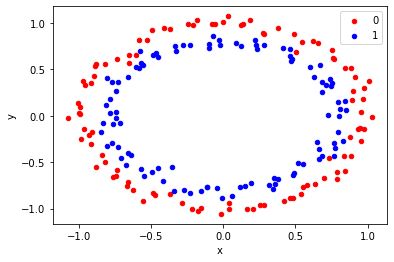

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=200, noise=0.05)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color = colors[key])
plt.show()    

## MLP

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Now, let's run the same model with linear kernel, as before:

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

input_dim = X_train.shape[1]
output_dim = 1

model = Sequential()
model.add(Dense(50, input_dim=input_dim))
model.add(Activation('linear'))
model.add(Dense(50))
model.add(Activation('linear'))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

model.fit(X_train,y_train,epochs=10)

prediction_class = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
prediction_prob = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
______________________________________________________

In [7]:
print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Accuracy: 0.4
AUC: 0.4502857142857143


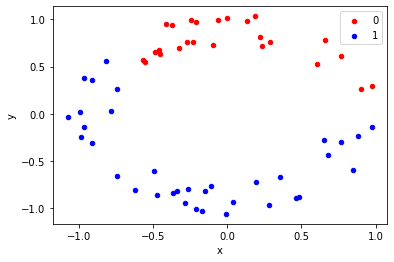

In [28]:
df = pd.DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=prediction_class[:]))

colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

The linear kernel is clearly not suitable. Let's try something different:

# Different hyperparameters

Let's explore a range of hyperparameters. More specifically, we will focus on:

- Activation function
- Number of neurons in a hidden layer
- Number of layers
- Learning rate
- Number of epochs

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

def nn_grid_search(parameters,n_folds,X_train,y_train):
    
    # First, create the neural network model
    def nn_model(kernel,no_neurons,learning_rate,epochs,no_layers):
        model = Sequential()
        model.add(Dense(no_neurons, input_dim=X_train.shape[1]))
        model.add(Activation(kernel))
        
        # Extra hidden layers
        for _ in range(0,no_layers):
            model.add(Dense(no_neurons))
            model.add(Activation(kernel))
            
        # Output
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

        return model
    
    # Next, apply the grid search using the parameters for your neural network model
    grid_search = GridSearchCV(KerasClassifier(nn_model), parameters, cv=n_folds, scoring='roc_auc')
    
    # Fit the data
    grid_search.fit(X_train, y_train.ravel())
    
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']
    
    return means, stds, params

Next, we run the grid search:

In [33]:
parameters = {'no_neurons':[10,20],'kernel':['relu','linear'],'no_layers':[1,2],'learning_rate':[0.1,0.01,0.001],'epochs':[5,10],'verbose':[0]}
n_folds = 5

means, stds, params = nn_grid_search(parameters,n_folds,X_train,y_train)

print('Mean AUC (+/- standard deviation), for parameters')
for mean, std, param_o in zip(means, stds, params):
    print('%0.3f (+/- %0.03f) for %r'% (mean, std, param_o))

Mean AUC (+/- standard deviation), for parameters
0.455 (+/- 0.034) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 10, 'verbose': 0}
0.630 (+/- 0.093) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 20, 'verbose': 0}
0.483 (+/- 0.114) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 10, 'verbose': 0}
0.543 (+/- 0.076) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 20, 'verbose': 0}
0.512 (+/- 0.106) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 10, 'verbose': 0}
0.479 (+/- 0.117) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 20, 'verbose': 0}
0.543 (+/- 0.077) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 2, 'no_neurons': 10, 'verbose': 0}
0.465 (+/- 0.085) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'n